# Weather Data Prediction 
### This notebook uses a Ridge regression model to predict high and low temperatures of data from May 2023 to July 2024.

## Import Libraries and Data

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
df = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

In [20]:
# Drop columns of no interest
df = df[['location', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility']]

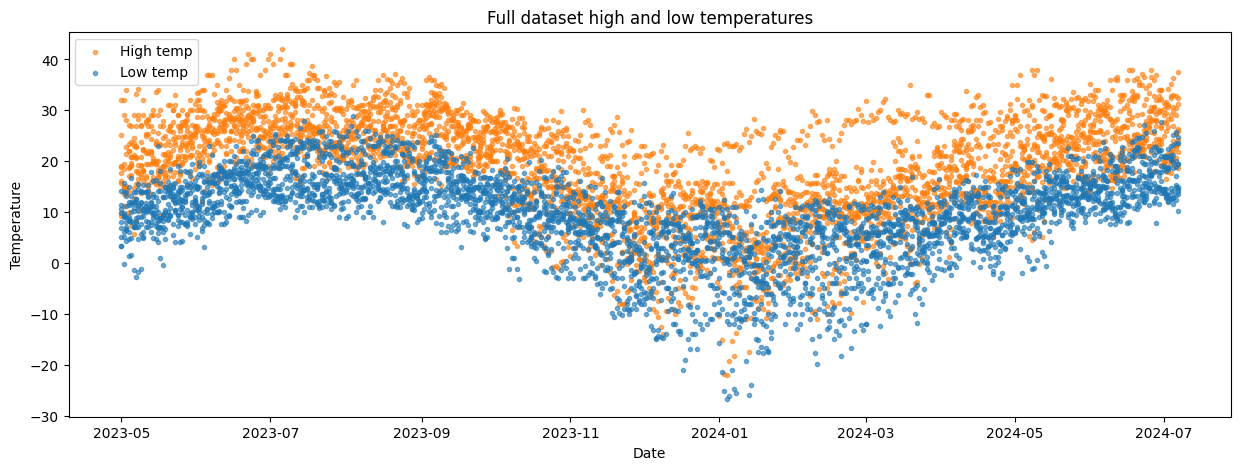

In [21]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(df.index, df['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(df.index, df['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## Train / Test Split 

In [22]:
# Split training and testing data by dates
train = df.loc[df.index < '2024-05-01']
test = df.loc[df.index >= '2024-05-01']

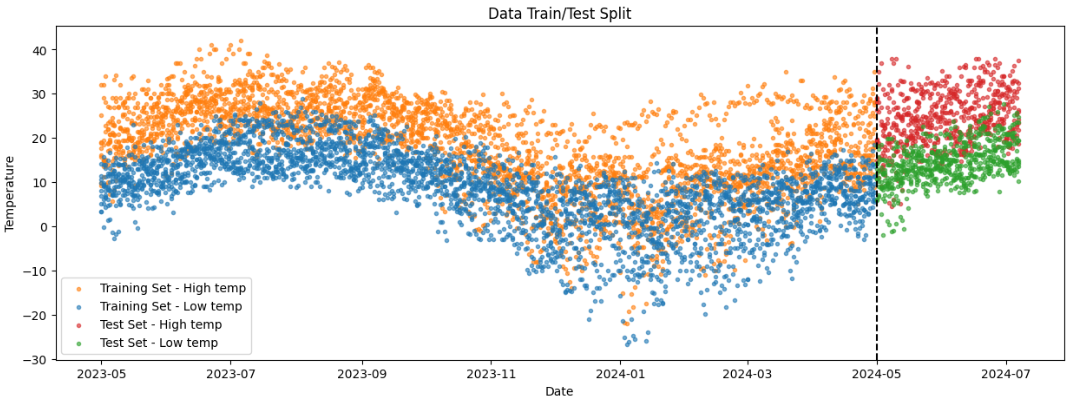

## Feature Engineering / Pandas for Data Preparation

In [23]:
# Significant features from ANOVA test
FEATURES_MAX = ['temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility']
FEATURES_MIN = ['temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility']

# Define targets for tempmax and tempmin
TARGET_MAX = 'tempmax'
TARGET_MIN = 'tempmin'

## Perform cross-validation on time series data - Evaluating Performance

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Define features and targets
X_train_max = train[FEATURES_MAX]
y_train_max = train[TARGET_MAX]
X_train_min = train[FEATURES_MIN]
y_train_min = train[TARGET_MIN]

X_test_max = test[FEATURES_MAX]
y_test_max = test[TARGET_MAX]
X_test_min = test[FEATURES_MIN]
y_test_min = test[TARGET_MIN]

# Scaling features
scaler_max = StandardScaler()
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_test_max_scaled = scaler_max.transform(X_test_max)

scaler_min = StandardScaler()
X_train_min_scaled = scaler_min.fit_transform(X_train_min)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Initialize the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
}

# Perform cross-validation for TempMax
print("Results for TempMax:")
scores_r2_max = cross_val_score(model, X_train_max_scaled, y_train_max, cv=tscv, scoring='r2')
scores_mse_max = cross_val_score(model, X_train_max_scaled, y_train_max, cv=tscv, scoring='neg_mean_squared_error')
scores_mse_max = -scores_mse_max  # Convert MSE to positive
scores_rmse_max = np.sqrt(scores_mse_max)

print(f"R² Scores: {scores_r2_max}")
print(f"Mean R²: {scores_r2_max.mean()} ± {scores_r2_max.std()}")

print(f"MSE Scores: {scores_mse_max}")
print(f"Mean MSE: {scores_mse_max.mean()} ± {scores_mse_max.std()}")

print(f"RMSE Scores: {scores_rmse_max}")
print(f"Mean RMSE: {scores_rmse_max.mean()} ± {scores_rmse_max.std()}\n")

# Perform cross-validation for TempMin
print("Results for TempMin:")
scores_r2_min = cross_val_score(model, X_train_min_scaled, y_train_min, cv=tscv, scoring='r2')
scores_mse_min = cross_val_score(model, X_train_min_scaled, y_train_min, cv=tscv, scoring='neg_mean_squared_error')
scores_mse_min = -scores_mse_min  # Convert MSE to positive
scores_rmse_min = np.sqrt(scores_mse_min)

print(f"R² Scores: {scores_r2_min}")
print(f"Mean R²: {scores_r2_min.mean()} ± {scores_r2_min.std()}")

print(f"MSE Scores: {scores_mse_min}")
print(f"Mean MSE: {scores_mse_min.mean()} ± {scores_mse_min.std()}")

print(f"RMSE Scores: {scores_rmse_min}")
print(f"Mean RMSE: {scores_rmse_min.mean()} ± {scores_rmse_min.std()}\n")

# Fit and evaluate model on the test set
model.fit(X_train_max_scaled, y_train_max)
y_pred_max = model.predict(X_test_max_scaled)
test_r2_max = r2_score(y_test_max, y_pred_max)
test_mse_max = mean_squared_error(y_test_max, y_pred_max)
test_rmse_max = np.sqrt(test_mse_max)

print("Test Set Evaluation for TempMax:")
print(f"R² Score: {test_r2_max}")
print(f"MSE: {test_mse_max}")
print(f"RMSE: {test_rmse_max}\n")

model.fit(X_train_min_scaled, y_train_min)
y_pred_min = model.predict(X_test_min_scaled)
test_r2_min = r2_score(y_test_min, y_pred_min)
test_mse_min = mean_squared_error(y_test_min, y_pred_min)
test_rmse_min = np.sqrt(test_mse_min)

print("Test Set Evaluation for TempMin:")
print(f"R² Score: {test_r2_min}")
print(f"MSE: {test_mse_min}")
print(f"RMSE: {test_rmse_min}")


Results for TempMax:
R² Scores: [0.99284581 0.99478636 0.97475582 0.99598815 0.99695791]
Mean R²: 0.991066808809417 ± 0.00827010247446201
MSE Scores: [0.34554482 0.19362096 3.46882382 0.2771701  0.1749067 ]
Mean MSE: 0.8920132797814209 ± 1.2898531798569617
RMSE Scores: [0.5878306  0.44002382 1.86247787 0.52646947 0.41821849]
Mean RMSE: 0.7670040493217697 ± 0.5511062221617798

Results for TempMin:
R² Scores: [0.96711135 0.97193049 0.98075866 0.99723431 0.99140201]
Mean R²: 0.9816873634504306 ± 0.011354304653905311
MSE Scores: [1.02839897 0.56206058 1.95431595 0.10132874 0.43250332]
Mean MSE: 0.8157215114754098 ± 0.6423684411361491
RMSE Scores: [1.01410008 0.74970699 1.39796851 0.31832176 0.65764985]
Mean RMSE: 0.8275494376320334 ± 0.36177816372787786

Test Set Evaluation for TempMax:
R² Score: 0.9942101364801141
MSE: 0.20712480392156885
RMSE: 0.4551096614241109

Test Set Evaluation for TempMin:
R² Score: 0.9955269337820928
MSE: 0.09178753758169937
RMSE: 0.3029645813980561


## Hyperparameter tuning to improve model performance

In [26]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define a more refined parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the features and targets from training data
X_train_max = train[FEATURES_MAX]
y_train_max = train[TARGET_MAX]
X_train_min = train[FEATURES_MIN]
y_train_min = train[TARGET_MIN]

# Define the features and targets from testing data
X_test_max = test[FEATURES_MAX]
y_test_max = test[TARGET_MAX]
X_test_min = test[FEATURES_MIN]
y_test_min = test[TARGET_MIN]

# Scaling features (if necessary)
scaler_max = StandardScaler()
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_test_max_scaled = scaler_max.transform(X_test_max)

scaler_min = StandardScaler()
X_train_min_scaled = scaler_min.fit_transform(X_train_min)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV for TempMax
random_search_max = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                       n_iter=50, cv=tscv, verbose=2, n_jobs=-1, scoring='r2')

# Fit RandomizedSearchCV for TempMax
random_search_max.fit(X_train_max_scaled, y_train_max)

# Check for failed combinations
results_max = random_search_max.cv_results_
for i in range(len(results_max['params'])):
    if np.isnan(results_max['mean_test_score'][i]):
        print(f"Combination {results_max['params'][i]} failed for TempMax.")

# Print the best parameters and best score for TempMax
print("Best parameters for TempMax:", random_search_max.best_params_)
print("Best R² score for TempMax:", random_search_max.best_score_)

# Train the final model with the best parameters on the entire training data for TempMax
rf_max = RandomForestRegressor(**random_search_max.best_params_, random_state=42)
rf_max.fit(X_train_max_scaled, y_train_max)

# Predict on the test set for TempMax
y_pred_max = rf_max.predict(X_test_max_scaled)

# Calculate evaluation metrics for TempMax
mae_max = mean_absolute_error(y_test_max, y_pred_max)
mse_max = mean_squared_error(y_test_max, y_pred_max)
rmse_max = np.sqrt(mse_max)
r2_max = r2_score(y_test_max, y_pred_max)

print(f"TempMax - MAE: {mae_max}")
print(f"TempMax - MSE: {mse_max}")
print(f"TempMax - RMSE: {rmse_max}")
print(f"TempMax - R²: {r2_max}")

# Initialize RandomizedSearchCV for TempMin
random_search_min = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                       n_iter=50, cv=tscv, verbose=2, n_jobs=-1, scoring='r2')

# Fit RandomizedSearchCV for TempMin
random_search_min.fit(X_train_min_scaled, y_train_min)

# Check for failed combinations
results_min = random_search_min.cv_results_
for i in range(len(results_min['params'])):
    if np.isnan(results_min['mean_test_score'][i]):
        print(f"Combination {results_min['params'][i]} failed for TempMin.")

# Print the best parameters and best score for TempMin
print("Best parameters for TempMin:", random_search_min.best_params_)
print("Best R² score for TempMin:", random_search_min.best_score_)

# Train the final model with the best parameters on the entire training data for TempMin
rf_min = RandomForestRegressor(**random_search_min.best_params_, random_state=42)
rf_min.fit(X_train_min_scaled, y_train_min)

# Predict on the test set for TempMin
y_pred_min = rf_min.predict(X_test_min_scaled)

# Calculate evaluation metrics for TempMin
mae_min = mean_absolute_error(y_test_min, y_pred_min)
mse_min = mean_squared_error(y_test_min, y_pred_min)
rmse_min = np.sqrt(mse_min)
r2_min = r2_score(y_test_min, y_pred_min)

print(f"TempMin - MAE: {mae_min}")
print(f"TempMin - MSE: {mse_min}")
print(f"TempMin - RMSE: {rmse_min}")
print(f"TempMin - R²: {r2_min}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; to

## Checking tempmax and tempmin residuals

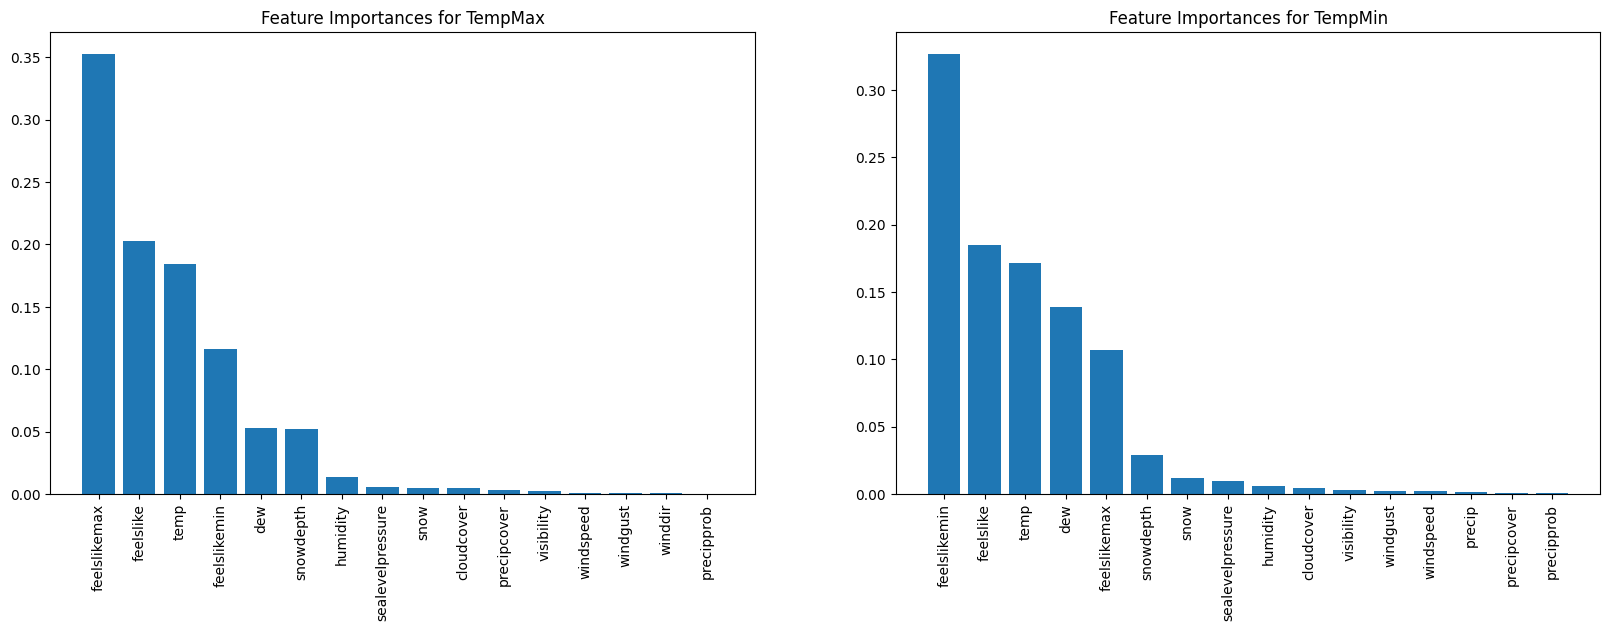

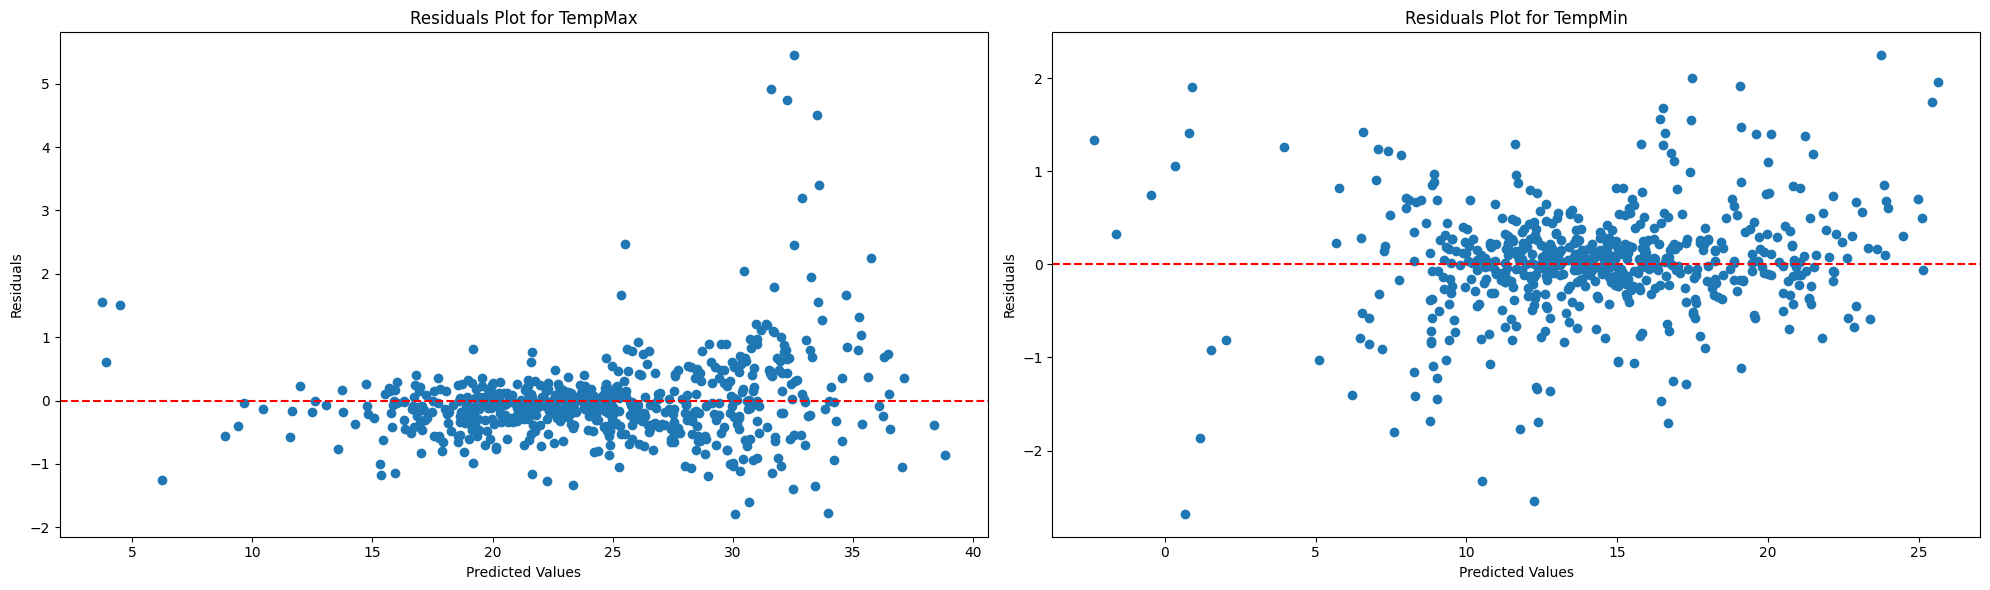

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rf_max and rf_min are your fitted models and FEATURES_MAX and FEATURES_MIN are defined

# Feature importance for TempMax
importances_max = rf_max.feature_importances_
indices_max = np.argsort(importances_max)[::-1]
feature_names_max = FEATURES_MAX

# Feature importance for TempMin
importances_min = rf_min.feature_importances_
indices_min = np.argsort(importances_min)[::-1]
feature_names_min = FEATURES_MIN

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot feature importances for TempMax
axes[0].bar(range(X_train_max.shape[1]), importances_max[indices_max])
axes[0].set_xticks(range(X_train_max.shape[1]))
axes[0].set_xticklabels([feature_names_max[i] for i in indices_max], rotation=90)
axes[0].set_title("Feature Importances for TempMax")

# Plot feature importances for TempMin
axes[1].bar(range(X_train_min.shape[1]), importances_min[indices_min])
axes[1].set_xticks(range(X_train_min.shape[1]))
axes[1].set_xticklabels([feature_names_min[i] for i in indices_min], rotation=90)
axes[1].set_title("Feature Importances for TempMin")

# Calculate residuals for TempMax
residuals_max = y_test_max - y_pred_max

# Calculate residuals for TempMin
residuals_min = y_test_min - y_pred_min

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot residuals for TempMax
axes[0].scatter(y_pred_max, residuals_max)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals Plot for TempMax')

# Plot residuals for TempMin
axes[1].scatter(y_pred_min, residuals_min)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot for TempMin')

# Adjust layout
plt.tight_layout()
plt.show()

## Check if removing low significance features depricates prediction accuracy

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Define a threshold for low importance features
importance_threshold = 0.01  # Adjust this threshold based on visual inspection

# Identify low importance features for TempMax
low_importance_features_max = [feature_names_max[i] for i in indices_max if importances_max[i] < importance_threshold]
print(f"Low importance features for TempMax: {low_importance_features_max}")

# Identify low importance features for TempMin
low_importance_features_min = [feature_names_min[i] for i in indices_min if importances_min[i] < importance_threshold]
print(f"Low importance features for TempMin: {low_importance_features_min}")

# Remove low importance features from the training data
X_train_max_reduced = X_train_max.drop(columns=low_importance_features_max)
X_train_min_reduced = X_train_min.drop(columns=low_importance_features_min)

# Retrain and evaluate the model using cross-validation for TempMax
model_max_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
scores_r2_max_reduced = cross_val_score(model_max_reduced, X_train_max_reduced, y_train_max, cv=tscv, scoring='r2')
scores_mse_max_reduced = -cross_val_score(model_max_reduced, X_train_max_reduced, y_train_max, cv=tscv, scoring='neg_mean_squared_error')
scores_rmse_max_reduced = np.sqrt(scores_mse_max_reduced)

print(f"Mean R² (reduced) for TempMax: {scores_r2_max_reduced.mean()} ± {scores_r2_max_reduced.std()}")
print(f"Mean MSE (reduced) for TempMax: {scores_mse_max_reduced.mean()} ± {scores_mse_max_reduced.std()}")
print(f"Mean RMSE (reduced) for TempMax: {scores_rmse_max_reduced.mean()} ± {scores_rmse_max_reduced.std()}")

# Retrain and evaluate the model using cross-validation for TempMin
model_min_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
scores_r2_min_reduced = cross_val_score(model_min_reduced, X_train_min_reduced, y_train_min, cv=tscv, scoring='r2')
scores_mse_min_reduced = -cross_val_score(model_min_reduced, X_train_min_reduced, y_train_min, cv=tscv, scoring='neg_mean_squared_error')
scores_rmse_min_reduced = np.sqrt(scores_mse_min_reduced)

print(f"Mean R² (reduced) for TempMin: {scores_r2_min_reduced.mean()} ± {scores_r2_min_reduced.std()}")
print(f"Mean MSE (reduced) for TempMin: {scores_mse_min_reduced.mean()} ± {scores_mse_min_reduced.std()}")
print(f"Mean RMSE (reduced) for TempMin: {scores_rmse_min_reduced.mean()} ± {scores_rmse_min_reduced.std()}")


Low importance features for TempMax: ['sealevelpressure', 'snow', 'cloudcover', 'precipcover', 'visibility', 'windspeed', 'windgust', 'winddir', 'precipprob']
Low importance features for TempMin: ['sealevelpressure', 'humidity', 'cloudcover', 'visibility', 'windgust', 'windspeed', 'precip', 'precipcover', 'precipprob']
Mean R² (reduced) for TempMax: 0.991774760689999 ± 0.007464645264718043
Mean MSE (reduced) for TempMax: 0.8128298014571946 ± 1.1677914700325147
Mean RMSE (reduced) for TempMax: 0.7350164190529194 ± 0.522092582958059
Mean R² (reduced) for TempMin: 0.9799177606966726 ± 0.011738455049684625
Mean MSE (reduced) for TempMin: 0.890456288888889 ± 0.665716093194025
Mean RMSE (reduced) for TempMin: 0.874131427836257 ± 0.35545820536011785


## Defining Features after Removing Low Impact Features

In [ ]:
# Define features after removing low imoprtance features from cross validation test
SIGNIFICANT_FEATURES_MAX = ['temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'snowdepth', 'winddir']
SIGNIFICANT_FEATURES_MIN = ['temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'snowdepth']

### Remove Features of low importance based on cross validation results
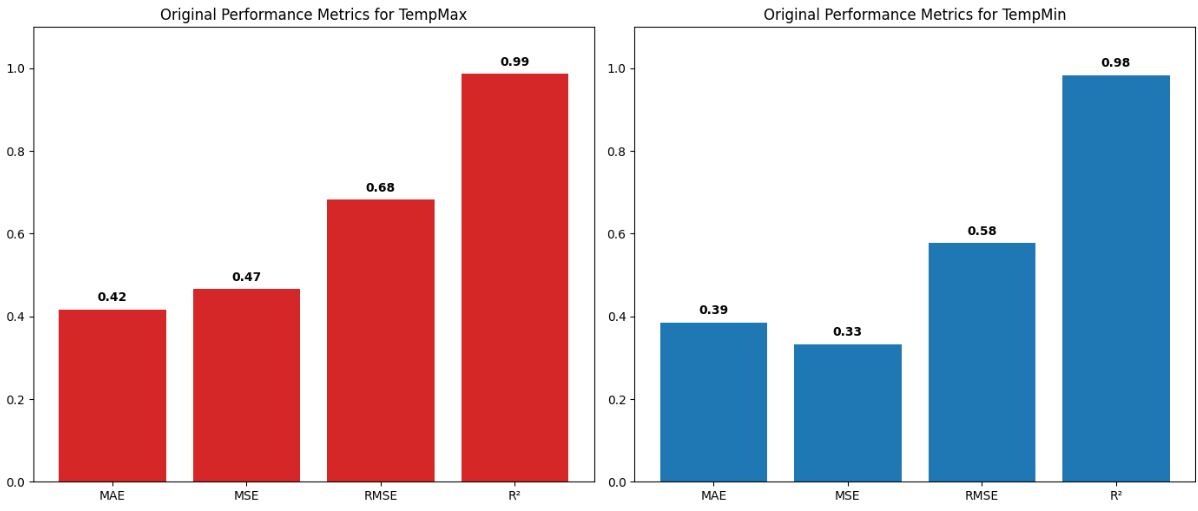 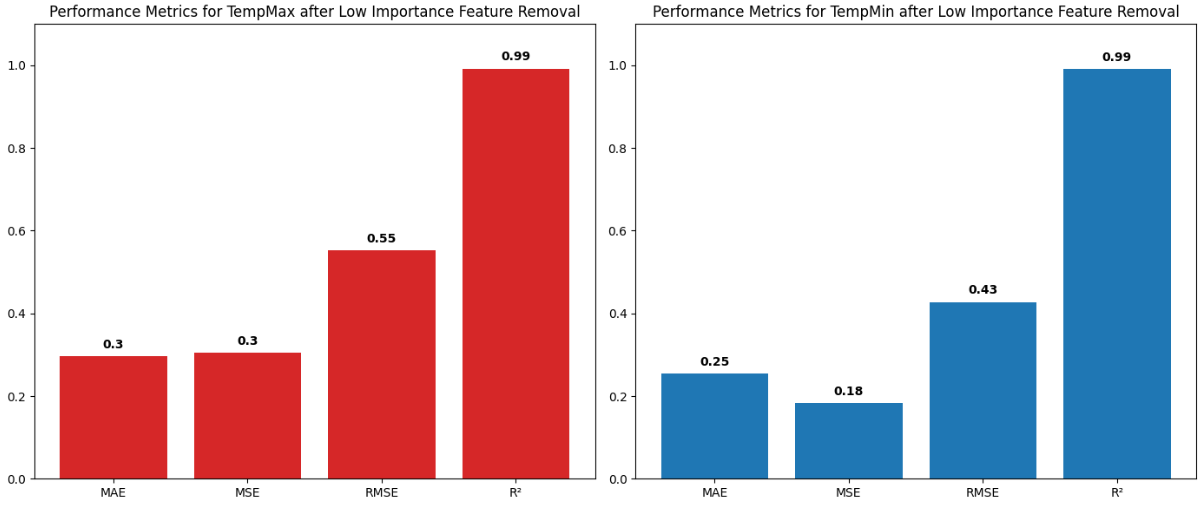

## Visualize Feature/Target Relationship

## OFFICIAL: Create Model - RandomForestRegressor Model Evaluation

In [ ]:
# Import model that passed cross validation tests
from sklearn.ensemble import RandomForestRegressor



## Analysis / Presentation of Results

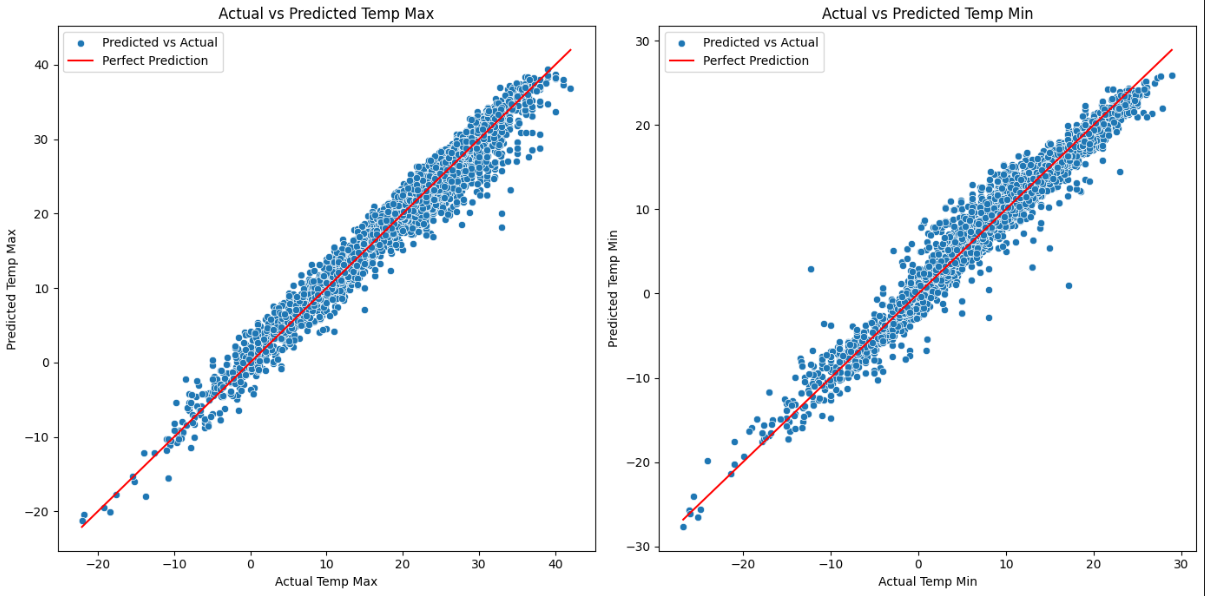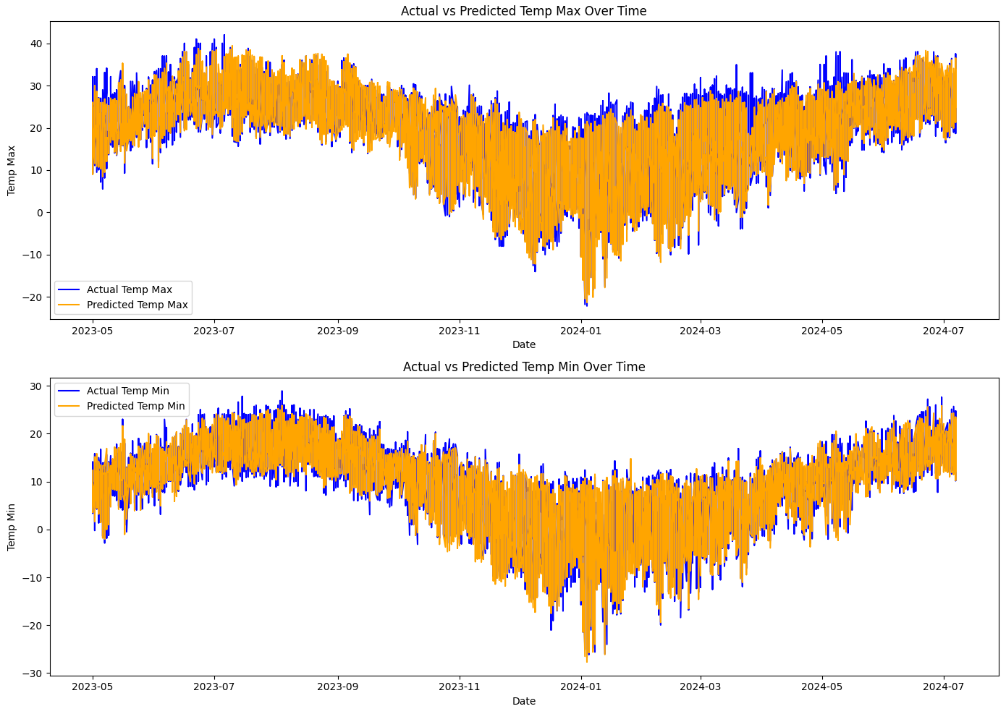

## Store Results

# Calculate metrics to check prediction accuracy

# Calculate PICP (prediction interval coverage probability) to determine model reliability